In [2]:
import pandas as pd
import numpy as np

import ruptures as rpt
from ruptures.metrics import precision_recall
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

import lightgbm as lgb
import seaborn as sns

In [3]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 9]

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

In [5]:
df = pd.read_csv('/Users/estyle-150/github/my_signage/data/processed/processed20240826.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df

,y,client,close,price_am,price_pm,is_train,price,year,month,weekday,...,price_am_lag_7,price_am_lag_365,price_pm_lag_1,price_pm_lag_7,price_pm_lag_365,price_am_moving_avg_7,price_am_moving_avg_30,price_pm_moving_avg_7,price_pm_moving_avg_30,day
datetime,,,,,,,,,,,,,,,,,,,,,
2010-07-01,17,0,0,0.192308,0.076923,1,0.134615,2010,7,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2010-07-02,18,0,0,0.692308,0.423077,1,0.557692,2010,7,4,...,NaN,NaN,0.076923,NaN,NaN,NaN,NaN,NaN,NaN,2
2010-07-03,20,0,0,1.807692,1.192308,1,1.500000,2010,7,5,...,NaN,NaN,0.423077,NaN,NaN,NaN,NaN,NaN,NaN,3
2010-07-04,20,0,0,1.407407,0.925926,1,1.166667,2010,7,6,...,NaN,NaN,1.192308,NaN,NaN,NaN,NaN,NaN,NaN,4
2010-07-05,14,0,0,0.346154,0.192308,1,0.269231,2010,7,0,...,NaN,NaN,0.925926,NaN,NaN,NaN,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-03-27,0,0,0,5.000000,4.000000,0,4.500000,2017,3,0,...,3.0,5.0,4.000000,4.0,4.0,3.857143,2.166667,4.000000,2.166667,27
2017-03-28,0,0,0,4.000000,4.000000,0,4.000000,2017,3,1,...,4.0,4.0,4.000000,4.0,4.0,3.857143,2.233333,4.000000,2.233333,28
2017-03-29,0,0,0,3.000000,3.000000,0,3.000000,2017,3,2,...,2.0,4.0,4.000000,4.0,4.0,4.000000,2.266667,3.857143,2.266667,29


In [6]:
# 使用するカラム
list_no = [0, 2, 3, 4, 5, 6, 7, 8, 9]
use_list = [df.columns[i] for i in list_no]

In [7]:
#df = df[my_bkps[0]:]
df_use = df[use_list]
df_use

,y,close,price_am,price_pm,is_train,price,year,month,weekday
datetime,,,,,,,,,
2010-07-01,17,0,0.192308,0.076923,1,0.134615,2010,7,3
2010-07-02,18,0,0.692308,0.423077,1,0.557692,2010,7,4
2010-07-03,20,0,1.807692,1.192308,1,1.500000,2010,7,5
2010-07-04,20,0,1.407407,0.925926,1,1.166667,2010,7,6
2010-07-05,14,0,0.346154,0.192308,1,0.269231,2010,7,0
...,...,...,...,...,...,...,...,...,...
2017-03-27,0,0,5.000000,4.000000,0,4.500000,2017,3,0
2017-03-28,0,0,4.000000,4.000000,0,4.000000,2017,3,1
2017-03-29,0,0,3.000000,3.000000,0,3.000000,2017,3,2


In [8]:
train_data = df_use[df_use['is_train']==1].copy()
test_data = df_use[df_use['is_train']==0].copy()

train_data.drop(['is_train'], axis=1, inplace=True)
test_data.drop(['y', 'is_train'], axis=1, inplace=True)

In [9]:
y = train_data['y']

In [10]:
def make_sequence_data(y, num_sequence):
  num_data = len(y)
  seq_data = []
  target_data = []
  for i in range(num_data - num_sequence):
    seq_data.append(y[i : i + num_sequence])
    target_data.append(y[i+num_sequence : i+num_sequence+1])
  seq_arr = np.array(seq_data)
  target_arr = np.array(target_data)
  return seq_arr, target_arr

In [11]:
seq_length = 30
y_seq, y_target = make_sequence_data(y, seq_length)

In [12]:
num_valid = 365
y_seq_train = y_seq[:-num_valid]
y_seq_valid = y_seq[-num_valid:]
y_target_train = y_target[:-num_valid]
y_target_valid = y_target[-num_valid:]

In [ ]:
y_seq_t = torch.FloatTensor(y_seq_train)
y_target_t = torch.FloatTensor(y_target_train)

In [19]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size)
    self.linear = nn.Linear(self.hidden_size, 1)

  def forward(self, x):
    x, _ = self.lstm(x)
    x_last = x[-1]
    x = self.linear(x_last)
    return x

In [4]:
class Predictor(nn.Module):
    def __init__(self, inputDim, hiddenDim, OutputDim):
        super(Predictor, self).__init__()

        self.rnn = nn.LSTM(input_size=inputDim, 
                           hidden_size=hiddenDim,
                           batch_first=True)
        self.output_layer = nn.Liniar(hiddenDim, outputDim)

    def forward(self, inputs, hidden0=None):
        output, (hidden, cell) = self.rnn(inputs, hidden0)
        output = self.output_layer(output[:, -1, :])
        return output

In [5]:
class PredictSimpleFormulaNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, batch_first):
        super(PredictSimpleFormulaNet, self).__init__()
        self.rnn = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            batch_first = batch_first)
        self.output_layer = nn.Linear(hidden_size, output_size)

        nn.init.xavier_normal_(self.rnn.weight_ih_l0)
        nn.init.orthogonal_(self.rnn.weight_hh_l0)

    def forward(self, inputs):
        h, _= self.rnn(inputs)
        output = self.output_layer(h[:, -1])

        return output


In [6]:
class Train():
    def __init__(self, input_size, output_size, hidden_size, batch_first, lr):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print("device：", self.device)
        self.net = PredictSimpleFormulaNet(input_size, output_size, hidden_size, batch_first).to(self.device)
        self.criterion = nn.MSELoss(reduction='mean')
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr, betas=(0.9, 0.999), amsgrad=True)

    def set_formula_const_arg(self, sin_a, cos_a, sin_t, cos_t):
        self.f = SimpleFormula(sin_a, cos_a, sin_t, cos_t)

    def make_dataset(self, dataset_num, sequence_length, t_start, calc_mode="sin"):
        dataset_inputs = []
        dataset_labels = []
        dataset_times = []
        for t in range(dataset_num):
            if calc_mode == "sin":
                dataset_inputs.append([self.f.sin(t_start + t + i) for i in range(sequence_length)])
                dataset_labels.append([self.f.sin(t_start + t + sequence_length)])
            elif calc_mode == "cos":
                dataset_inputs.append([self.f.cos(t_start + t + i) for i in range(sequence_length)])
                dataset_labels.append([self.f.cos(t_start + t + sequence_length)])
            dataset_times.append(t_start + t + sequence_length)
        print("test = {}, {}, {}".format(np.array(dataset_inputs).shape,  np.array(dataset_labels).shape, np.array(dataset_times).shape))
        return np.array(dataset_inputs),  np.array(dataset_labels), np.array(dataset_times)

    def train_step(self, inputs, labels):
        inputs = torch.Tensor(inputs).to(self.device)
        labels = torch.Tensor(labels).to(self.device)
        self.net.train()
        preds = self.net(inputs)
        loss = self.criterion(preds, labels)
        self.optimizer.zero_grad()
        loss.backward()
        # 勾配が大きくなりすぎると計算が不安定になるので、clipで最大でも勾配2.0に留める
        nn.utils.clip_grad_value_(self.net.parameters(), clip_value=2.0)
        self.optimizer.step()

        return loss, preds

    def test_step(self, inputs, labels):
        inputs = torch.Tensor(inputs).to(self.device)
        labels = torch.Tensor(labels).to(self.device)
        self.net.eval()
        preds = self.net(inputs)
        loss = self.criterion(preds, labels)

        return loss, preds

    def train(self, train_inputs, train_labels, test_inputs, test_labels, epochs, batch_size, sequence_length, input_size):
        torch.backends.cudnn.benchmark = True   # ネットワークがある程度固定であれば、高速化させる

        n_batches_train = int(train_inputs.shape[0] / batch_size)
        n_batches_test = int(test_inputs.shape[0] / batch_size)
        for epoch in range(epochs):
            print('-------------')
            print('Epoch {}/{}'.format(epoch+1, epochs))
            print('-------------')
            train_loss = 0.
            test_loss = 0.
            train_inputs_shuffle, train_labels_shuffle = shuffle(train_inputs, train_labels)
            for batch in range(n_batches_train):
                start = batch * batch_size
                end = start + batch_size
                loss, _ = self.train_step(np.array(train_inputs_shuffle[start:end]).reshape(-1, sequence_length, input_size), np.array(train_labels_shuffle[start:end]).reshape(-1, input_size))
                train_loss += loss.item()

            for batch in range(n_batches_test):
                start = batch * batch_size
                end = start + batch_size
                loss, _ = self.test_step(np.array(test_inputs[start:end]).reshape(-1, sequence_length, input_size), np.array(test_labels[start:end]).reshape(-1, input_size))
                test_loss += loss.item()

            train_loss /= float(n_batches_train)
            test_loss /= float(n_batches_test)
            print('loss: {:.3}, test_loss: {:.3}'.format(train_loss, test_loss))

    def pred_result_plt(self, test_inputs, test_labels, test_times, sequence_length, input_size):
        print('-------------')
        print("start predict test!!")
        self.net.eval()
        preds = []
        for i in range(len(test_inputs)):
            input = np.array(test_inputs[i]).reshape(-1, sequence_length, input_size)
            input = torch.Tensor(input).to(self.device)
            pred = self.net(input).data.cpu().numpy()
            preds.append(pred[0].tolist())
        preds = np.array(preds)
        test_labels = np.array(test_labels)
        pred_epss = np.abs(test_labels - preds)
        print("pred_epss_max = {}".format(pred_epss.max()))
        #以下グラフ描画
        plt.plot(test_times, preds)
        plt.plot(test_times, test_labels, c='#00ff00')
        plt.xlabel('t')
        plt.ylabel('y')
        plt.legend(['label', 'pred'])
        plt.title('compare label and pred')
        plt.show()

    def confirm_input_and_label_plot(self, calc_mode, inputs, labels, times):
        #この関数はinputとlabelを可視化するためのコードで基本的に使う必要のない関数です
        print('-------------')
        print("confirm_input_and_label!!")
        re_inputs = inputs[:, -1]
        #以下グラフ描画
        plt.plot(times[:-3], re_inputs[:-3], marker="o")
        plt.plot(times[-3:], re_inputs[-3:], marker="o")
        plt.plot(times[-1]+1.0, labels[-1], marker="o")
        plt.xlabel('t')
        plt.ylabel('y')
        plt.legend([calc_mode, 'input', 'label'])
        plt.title('confirm input and label')
        plt.show()



In [ ]:
if __name__ == '__main__':
    '''
    定数
    '''
    dataset_num = 250
    sequence_length = 3
    t_start = -100.0
    sin_a = 2.0
    cos_a = 2.0
    sin_t = 25.0
    cos_t = 25.0
    calc_mode = "sin"
    # model pram
    input_size = 1
    output_size = 1
    hidden_size = 64
    batch_first = True
    # train pram
    lr = 0.001
    epochs = 15
    batch_size = 4
    test_size = 0.2
    '''
    学習用の関数を呼び出す
    '''
    train = Train(input_size, output_size, hidden_size, batch_first, lr)
    train.set_formula_const_arg(sin_a, cos_a, sin_t, cos_t)
    dataset_inputs, dataset_labels, dataset_times = train.make_dataset(dataset_num, sequence_length, t_start, calc_mode=calc_mode)
    print("dataset_inputs = {}, dataset_labels = {}".format(dataset_inputs.shape, dataset_labels.shape))
    train_inputs, test_inputs, train_labels, test_labels = train_test_split(dataset_inputs, dataset_labels, test_size=test_size, shuffle=False)
    train_times, test_times = train_test_split(dataset_times, test_size=test_size, shuffle=False)
    print("train_inputs = {}, train_labels = {}, test_inputs = {}, test_labels = {}".format(train_inputs.shape, train_labels.shape, test_inputs.shape, test_labels.shape))
    # train.confirm_input_and_label_plot(calc_mode, test_inputs, test_labels, test_times)
    train.train(train_inputs, train_labels, test_inputs, test_labels, epochs, batch_size, sequence_length, input_size)
    train.pred_result_plt(test_inputs, test_labels, test_times, sequence_length, input_size)



In [5]:
df = pd.read_csv('/Users/estyle-150/github/my_signage/data/processed/processed20240826.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df

,y,client,close,price_am,price_pm,is_train,price,year,month,weekday,...,price_am_lag_7,price_am_lag_365,price_pm_lag_1,price_pm_lag_7,price_pm_lag_365,price_am_moving_avg_7,price_am_moving_avg_30,price_pm_moving_avg_7,price_pm_moving_avg_30,day
datetime,,,,,,,,,,,,,,,,,,,,,
2010-07-01,17,0,0,0.192308,0.076923,1,0.134615,2010,7,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2010-07-02,18,0,0,0.692308,0.423077,1,0.557692,2010,7,4,...,NaN,NaN,0.076923,NaN,NaN,NaN,NaN,NaN,NaN,2
2010-07-03,20,0,0,1.807692,1.192308,1,1.500000,2010,7,5,...,NaN,NaN,0.423077,NaN,NaN,NaN,NaN,NaN,NaN,3
2010-07-04,20,0,0,1.407407,0.925926,1,1.166667,2010,7,6,...,NaN,NaN,1.192308,NaN,NaN,NaN,NaN,NaN,NaN,4
2010-07-05,14,0,0,0.346154,0.192308,1,0.269231,2010,7,0,...,NaN,NaN,0.925926,NaN,NaN,NaN,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-03-27,0,0,0,5.000000,4.000000,0,4.500000,2017,3,0,...,3.0,5.0,4.000000,4.0,4.0,3.857143,2.166667,4.000000,2.166667,27
2017-03-28,0,0,0,4.000000,4.000000,0,4.000000,2017,3,1,...,4.0,4.0,4.000000,4.0,4.0,3.857143,2.233333,4.000000,2.233333,28
2017-03-29,0,0,0,3.000000,3.000000,0,3.000000,2017,3,2,...,2.0,4.0,4.000000,4.0,4.0,4.000000,2.266667,3.857143,2.266667,29


In [6]:
pd.DataFrame(df.columns)

,0
0,y
1,client
2,close
3,price_am
4,price_pm
5,is_train
6,price
7,year
8,month
9,weekday


In [7]:
# 使用するカラム
list_no = [0, 2, 3, 4, 5, 6, 7, 8, 9]
use_list = [df.columns[i] for i in list_no]

In [8]:
################
### 変化点検知 ###
################

# コスト関数の設定
#model = "l2"
# アルゴの設定と学習
#algo = rpt.Dynp(model=model).fit(df[['y']])
# 変化点の検出
#my_bkps = algo.predict(n_bkps=3)
# 結果のプロット
#rpt.show.display(df[['y']], my_bkps, figsize=(12, 9))
#plt.show()
# 検出された変化点
#print(my_bkps)


In [9]:
#df = df[my_bkps[0]:]
df = df[use_list]
df

,y,close,price_am,price_pm,is_train,price,year,month,weekday
datetime,,,,,,,,,
2010-07-01,17,0,0.192308,0.076923,1,0.134615,2010,7,3
2010-07-02,18,0,0.692308,0.423077,1,0.557692,2010,7,4
2010-07-03,20,0,1.807692,1.192308,1,1.500000,2010,7,5
2010-07-04,20,0,1.407407,0.925926,1,1.166667,2010,7,6
2010-07-05,14,0,0.346154,0.192308,1,0.269231,2010,7,0
...,...,...,...,...,...,...,...,...,...
2017-03-27,0,0,5.000000,4.000000,0,4.500000,2017,3,0
2017-03-28,0,0,4.000000,4.000000,0,4.000000,2017,3,1
2017-03-29,0,0,3.000000,3.000000,0,3.000000,2017,3,2


In [158]:
train_data = df[df['is_train']==1].copy()
test_data = df[df['is_train']==0].copy()

train_data.drop(['is_train'], axis=1, inplace=True)
test_data.drop(['y', 'is_train'], axis=1, inplace=True)

In [159]:
# 開店日のみのデータ作成
train_data_open = train_data[train_data['close']==0].drop(['close'], axis=1, inplace=False)

In [160]:
test_data_open = test_data.drop(['close'],axis=1, inplace=False)

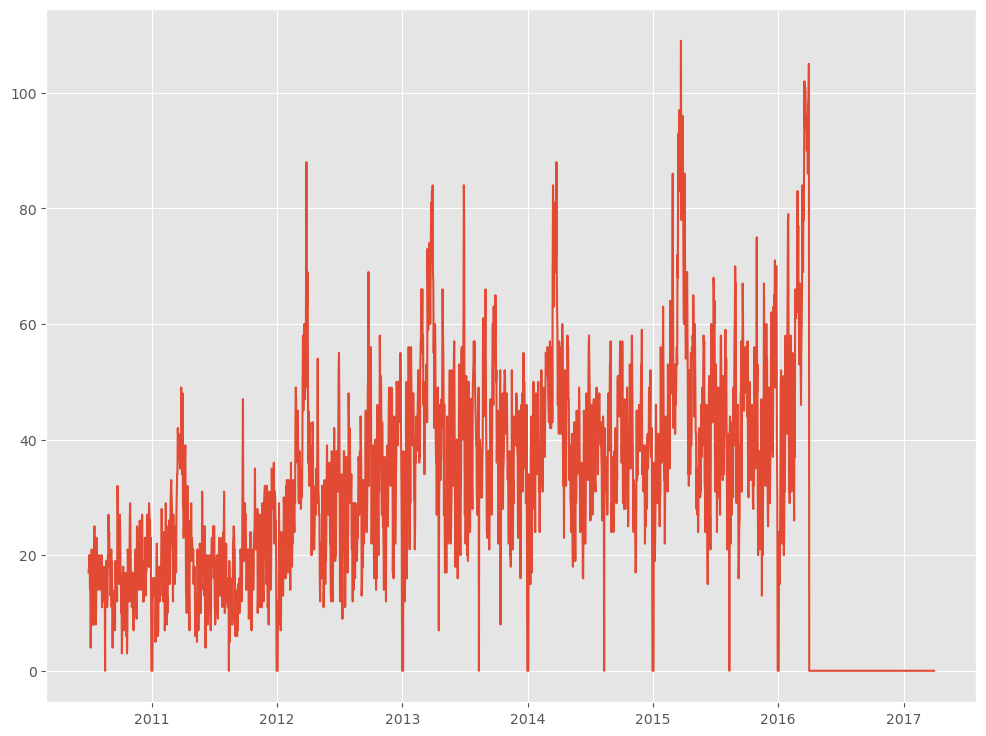

In [161]:
plt.plot(df['y'])